<a href="https://colab.research.google.com/github/Wook0111/ChAiJum-Ajou-SW-Challenge-/blob/main/Classification_with_pretrained_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports**

In [81]:
import os
import keras
import numpy as np
from glob import glob
from tqdm import tqdm 
from keras.preprocessing.image import ImageDataGenerator
from keras import Sequential
from keras.models import load_model
from keras.layers import Dense, GlobalAvgPool2D as GAP, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import ResNet152V2,VGG16

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**Training**

In [137]:
def training(model, train_data, validation_data, optimizer, loss, epochs, saving_name) :

  checkpoint_path = saving_name + ".ckpt"
  model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
  
  checkpoint = [
                EarlyStopping(patience=3, restore_best_weights=True),
                ModelCheckpoint(filepath=checkpoint_path, 
                                save_best_only=True,  
                                verbose=1)
  ]
  
  history = model.fit(train_data,
            validation_data=validation_data,
            epochs=epochs,
            callbacks=checkpoint,
            )


  return history

#**Evaluate**

In [48]:
def evaluate(model, test_data) :
  loss, acc = model.evaluate(test_data, verbose=2)
  print("test loss: %f, test accuracy: %f" %(loss, acc*100))

## **Model**
(Resnet152_V2)

In [180]:
def create_model_RESNET() :
  name = "ResNet152V2"

# Pretrained Model
  base_model = ResNet152V2(include_top=False, input_shape=(256,256,3), weights='imagenet')
  base_model.trainable = False # Freeze the Weights

  # Model 
  model = Sequential([
     base_model,
     GAP(),
     Dense(256, activation='relu'),
     Dropout(0.2),
     Dense(5, activation='softmax')
  ], name=name)

  return model

# **Experiment 1**
(Using DALL-E dataset)

## Data

Numbers of classes

In [50]:
train_path = '/content/drive/Shareddrives/dall_e/Picture/Train_data/'
test_path = '/content/drive/Shareddrives/dall_e/Picture/Test_data/'

In [51]:
tr_class_names=sorted(os.listdir(train_path))
tr_n_classes = len(tr_class_names)
print(f"Train Class Names: \n{tr_class_names}")
print(f"Total Number of Train Classes : {tr_n_classes}")

te_class_names=sorted(os.listdir(test_path))
te_n_classes = len(te_class_names)
print(f"Test Class Names: \n{te_class_names}")
print(f"Total Number of Test Classes : {te_n_classes}")

Train Class Names: 
['Bull', 'Cat', 'Dog', 'Horse', 'Sheep']
Total Number of Train Classes : 5
Test Class Names: 
['Bull_test', 'Cat_test', 'Dog_test', 'Horse_test', 'Sheep_test']
Total Number of Test Classes : 5


Class Distribution

In [52]:
tr_class_dis = [len(os.listdir(train_path + f"/{name}")) for name in tr_class_names]
print(f"Train Class Distribution : \n{tr_class_dis}")

Train Class Distribution : 
[1281, 1281, 1281, 1281, 1281]


Preprocessing

In [53]:
# Train Data
gen = ImageDataGenerator(
    rescale=1./255, 
    horizontal_flip=True, 
    vertical_flip=True, 
    rotation_range=20, 
    validation_split=0.2)


train_ds = gen.flow_from_directory(
    train_path, 
    target_size=(256,256), 
    class_mode='binary', 
    batch_size=32, 
    shuffle=True, 
    subset='training')

valid_ds = gen.flow_from_directory(
    train_path, 
    target_size=(256,256), 
    class_mode='binary', 
    batch_size=32, 
    shuffle=True, 
    subset='validation')



# Test Data
test_gen = ImageDataGenerator(
        rescale=1. / 255
        )

test_ds = test_gen.flow_from_directory(test_path, 
                                                  batch_size=1, 
                                                  target_size=(256, 256), 
                                                  class_mode='binary'
                                                  )

Found 5120 images belonging to 5 classes.
Found 1280 images belonging to 5 classes.
Found 1600 images belonging to 5 classes.


## Run

In [54]:
OPTIMIZER = 'adam'
LOSS = 'sparse_categorical_crossentropy'
EPOCHS = 10
SAVING_NAME = 'model_dalle'

model_dalle = create_model_RESNET()
model_dalle.summary()

Model: "ResNet152V2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 8, 8, 2048)        58331648  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 256)               524544    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 58,857,477
Trainable params: 525,829
Non-trainable params: 58,331,648
_____________________________________

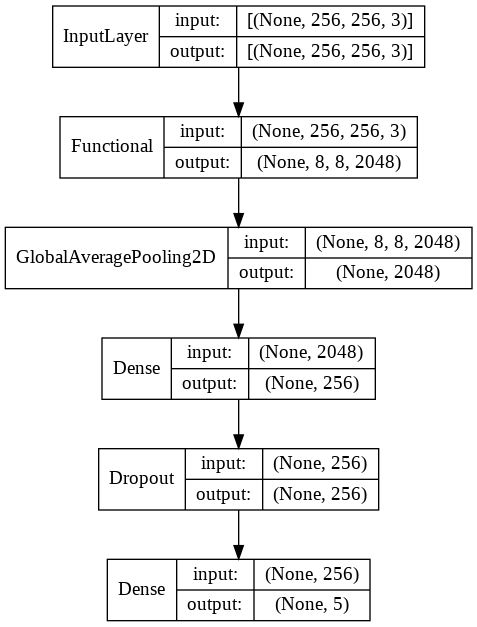

In [112]:
from keras.utils.vis_utils import plot_model
plot_model(model_dalle, show_shapes=True, show_layer_names=False)

In [55]:
history_dalle = training(model_dalle, train_ds, valid_ds, OPTIMIZER, LOSS, EPOCHS, SAVING_NAME)

Epoch 1/10
160/160 [==============================] - ETA: 0s - loss: 0.2598 - accuracy: 0.9141
Epoch 1: val_loss improved from inf to 0.25609, saving model to model_dalle.ckpt


160/160 [==============================] - 209s 1s/step - loss: 0.2598 - accuracy: 0.9141 - val_loss: 0.2561 - val_accuracy: 0.9187
Epoch 2/10
160/160 [==============================] - ETA: 0s - loss: 0.1417 - accuracy: 0.9520
Epoch 2: val_loss improved from 0.25609 to 0.22589, saving model to model_dalle.ckpt


160/160 [==============================] - 195s 1s/step - loss: 0.1417 - accuracy: 0.9520 - val_loss: 0.2259 - val_accuracy: 0.9312
Epoch 3/10
160/160 [==============================] - ETA: 0s - loss: 0.1028 - accuracy: 0.9656
Epoch 3: val_loss improved from 0.22589 to 0.18212, saving model to model_dalle.ckpt


160/160 [==============================] - 197s 1s/step - loss: 0.1028 - accuracy: 0.9656 - val_loss: 0.1821 - val_accuracy: 0.9367
Epoch 4/10
160/160 [==============================] - ETA: 0s - loss: 0.0828 - accuracy: 0.9697
Epoch 4: val_loss did not improve from 0.18212
160/160 [==============================] - 142s 888ms/step - loss: 0.0828 - accuracy: 0.9697 - val_loss: 0.2240 - val_accuracy: 0.9328
Epoch 5/10
160/160 [==============================] - ETA: 0s - loss: 0.0794 - accuracy: 0.9727
Epoch 5: val_loss did not improve from 0.18212
160/160 [==============================] - 141s 883ms/step - loss: 0.0794 - accuracy: 0.9727 - val_loss: 0.1927 - val_accuracy: 0.9414
Epoch 6/10
160/160 [==============================] - ETA: 0s - loss: 0.0602 - accuracy: 0.9781
Epoch 6: val_loss did not improve from 0.18212
160/160 [==============================] - 142s 885ms/step - loss: 0.0602 - accuracy: 0.9781 - val_loss: 0.2698 - val_accuracy: 0.9266


##Visualizaiton

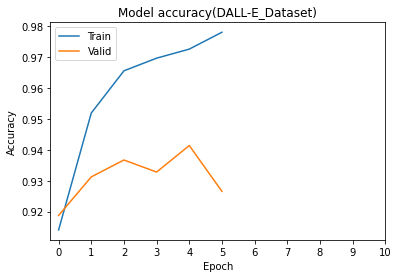

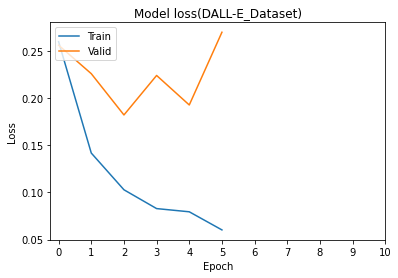

In [56]:
import matplotlib.pyplot as plt

plt.plot(history_dalle.history['accuracy'])
plt.plot(history_dalle.history['val_accuracy'])
plt.title('Model accuracy(DALL-E_Dataset)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10])
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

# 7 훈련 과정 시각화 (손실)
plt.plot(history_dalle.history['loss'])
plt.plot(history_dalle.history['val_loss'])
plt.title('Model loss(DALL-E_Dataset)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10])
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

## Evaluate

In [199]:
model_dalle = load_model('/content/'+SAVING_NAME+'.ckpt')

In [58]:
evaluate(model_dalle, test_ds)

1600/1600 - 42s - loss: 0.3379 - accuracy: 0.9106 - 42s/epoch - 26ms/step
test loss: 0.337910, test accuracy: 91.062498


#**Experiment 2**
(Using Kaggle dataset)

## Data

Numbers of classes

In [165]:
train_path = '/content/drive/Shareddrives/dall_e/Picture/Kaggle_Train_data/'
test_path = '/content/drive/Shareddrives/dall_e/Picture/Test_data/'

In [192]:
tr_class_names=sorted(os.listdir(train_path))
tr_n_classes = len(tr_class_names)
print(f"Train Class Names: \n{tr_class_names}")
print(f"Total Number of Train Classes : {tr_n_classes}")

te_class_names=sorted(os.listdir(test_path))
te_n_classes = len(te_class_names)
print(f"Test Class Names: \n{te_class_names}")
print(f"Total Number of Test Classes : {te_n_classes}")

Train Class Names: 
['Bull_train', 'Cat_train', 'Horse_train', 'Sheep_train', 'Train_dog']
Total Number of Train Classes : 5
Test Class Names: 
['Bull_test', 'Cat_test', 'Dog_test', 'Horse_test', 'Sheep_test']
Total Number of Test Classes : 5


Class Distribution

In [90]:
tr_class_dis = [len(os.listdir(train_path + f"/{name}")) for name in tr_class_names]
print(f"Train Class Distribution : \n{tr_class_dis}")

Train Class Distribution : 
[1280, 1280, 1280, 1280, 1280]


Preprocessing

In [193]:
# Train Data
gen = ImageDataGenerator(
    rescale=1./255, 
    horizontal_flip=True, 
    vertical_flip=False,  
    validation_split=0.2)


train_ds = gen.flow_from_directory(
    train_path, 
    target_size=(256,256), 
    class_mode='binary', 
    batch_size=32, 
    shuffle=True, 
    subset='training')

valid_ds = gen.flow_from_directory(
    train_path, 
    target_size=(256,256), 
    class_mode='binary', 
    batch_size=32, 
    shuffle=True, 
    subset='validation')



# Test Data
test_gen = ImageDataGenerator(
        rescale=1. / 255
        )

test_ds = test_gen.flow_from_directory(test_path, 
                                                  batch_size=1, 
                                                  target_size=(256, 256), 
                                                  class_mode='binary'
                                                  )

Found 5120 images belonging to 5 classes.
Found 1280 images belonging to 5 classes.
Found 1600 images belonging to 5 classes.


## Run

In [194]:
OPTIMIZER = 'adam'
LOSS = 'sparse_categorical_crossentropy'
EPOCHS = 10
SAVING_NAME = 'model_kaggle'

model_kaggle = create_model_RESNET()
model_kaggle.summary()

Model: "ResNet152V2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 8, 8, 2048)        58331648  
                                                                 
 global_average_pooling2d_17  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_34 (Dense)            (None, 256)               524544    
                                                                 
 dropout_17 (Dropout)        (None, 256)               0         
                                                                 
 dense_35 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 58,857,477
Trainable params: 525,829
Non-trainable params: 58,331,648
_____________________________________

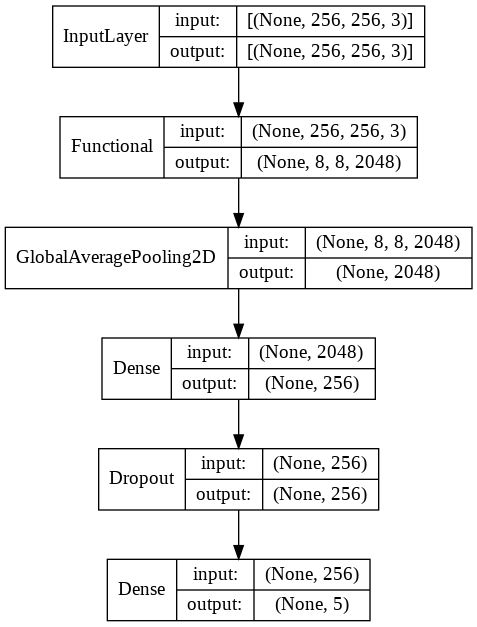

In [184]:
from keras.utils.vis_utils import plot_model
plot_model(model_kaggle, show_shapes=True, show_layer_names=False)

In [195]:
history_kaggle = training(model_kaggle, train_ds, valid_ds, OPTIMIZER, LOSS, EPOCHS, SAVING_NAME)

Epoch 1/10
160/160 [==============================] - ETA: 0s - loss: 0.2480 - accuracy: 0.9293
Epoch 1: val_loss improved from inf to 0.15875, saving model to model_kaggle.ckpt


160/160 [==============================] - 132s 776ms/step - loss: 0.2480 - accuracy: 0.9293 - val_loss: 0.1588 - val_accuracy: 0.9484
Epoch 2/10
160/160 [==============================] - ETA: 0s - loss: 0.1179 - accuracy: 0.9635
Epoch 2: val_loss improved from 0.15875 to 0.12169, saving model to model_kaggle.ckpt


160/160 [==============================] - 123s 770ms/step - loss: 0.1179 - accuracy: 0.9635 - val_loss: 0.1217 - val_accuracy: 0.9602
Epoch 3/10
160/160 [==============================] - ETA: 0s - loss: 0.0830 - accuracy: 0.9762
Epoch 3: val_loss did not improve from 0.12169
160/160 [==============================] - 66s 411ms/step - loss: 0.0830 - accuracy: 0.9762 - val_loss: 0.1398 - val_accuracy: 0.9547
Epoch 4/10
160/160 [==============================] - ETA: 0s - loss: 0.0579 - accuracy: 0.9830
Epoch 4: val_loss did not improve from 0.12169
160/160 [==============================] - 66s 409ms/step - loss: 0.0579 - accuracy: 0.9830 - val_loss: 0.1481 - val_accuracy: 0.9531
Epoch 5/10
160/160 [==============================] - ETA: 0s - loss: 0.0412 - accuracy: 0.9877
Epoch 5: val_loss did not improve from 0.12169
160/160 [==============================] - 66s 413ms/step - loss: 0.0412 - accuracy: 0.9877 - val_loss: 0.1764 - val_accuracy: 0.9469


## Visualization

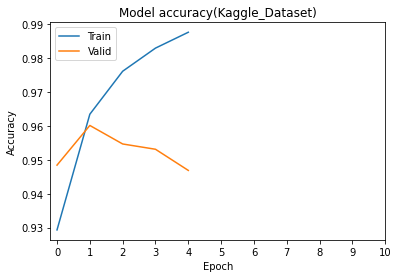

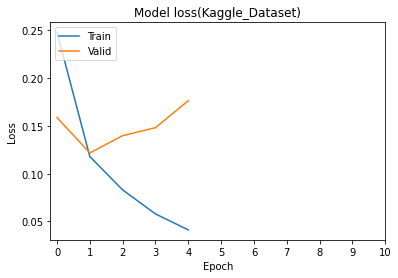

In [196]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history_kaggle.history['accuracy'])
plt.plot(history_kaggle.history['val_accuracy'])
plt.title('Model accuracy(Kaggle_Dataset)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10])
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

# Validation
plt.plot(history_kaggle.history['loss'])
plt.plot(history_kaggle.history['val_loss'])
plt.title('Model loss(Kaggle_Dataset)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10])
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

## Evaluate

In [189]:
model_kaggle = load_model('/content/'+SAVING_NAME+'.ckpt')

In [191]:
evaluate(model_kaggle, test_ds)

40/40 - 15s - loss: 0.1518 - accuracy: 0.9492 - 15s/epoch - 369ms/step
test loss: 0.151793, test accuracy: 94.921875
